# Projet 5 :  Modèles (avec pré-traitement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
import tqdm
from random import sample
from scipy import stats
import scipy.stats as st
from scipy.stats import hmean
from sklearn import linear_model, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from gensim import models, corpora
import gensim 

from itertools import groupby
import operator

from gensim.models import phrases, Phrases, coherencemodel
import stop_words 
import nltk 
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm_notebook()
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/05 - Projet 5/Main Project")

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flemeill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [2]:
# Import data
corpus = pd.read_csv('QueryResults.csv')

In [3]:
# Look where data is missing
corpus.isnull().sum(axis=0)

Body     0    
Title    32754
Score    0    
Tags     32753
dtype: int64

In [4]:
# Drop lines with missing values
corpus_filtered = corpus.dropna()
corpus_filtered.shape

(17246, 4)

In [5]:
corpus_filtered.head()

,Body,Title,Score,Tags
0,"<p>Does Visual Studio .NET have a way to toggle word-wrap on and off?</p>\n\n<p>I am used to this feature in Eclipse which allows you to right click and toggle word wrap on and off so that when you have long lines that extend out to the right, you don't have to move the bottom scroll bar right and left to read your code/html:\n<a href=""http://ahtik.com/blog/2006/06/18/first-alpha-of-eclipse-word-wrap-released/"" rel=""noreferrer"">http://ahtik.com/blog/2006/06/18/first-alpha-of-eclipse-word-wrap-released/</a></p>\n",How can I toggle word wrap in Visual Studio?,221,<visual-studio><word-wrap>
2,<p>I lost my MySQL username and password. How do I retrieve it?</p>\n,How do I retrieve my MySQL username and password?,132,<mysql>
5,"<p>I'd like a script to drop all tables whose name begins with a given string. I'm sure this can be done with some dynamic sql and the <code>INFORMATION_SCHEMA</code> tables.</p>\n\n<p>If anyone has a script, or can knock one up quickly, please post it.</p>\n\n<p>If no-one posts an answer before I figure it out myself, I'll post my solution.</p>\n",Drop all tables whose names begin with a certain string,121,<sql><sql-server><scripting><dynamic-sql>
7,"<p>The firewall I'm behind is running Microsoft ISA server in NTLM-only mode. Hash anyone have success getting their Ruby gems to install/update via Ruby SSPI gem or other method?</p>\n\n<p>... or am I just being lazy?</p>\n\n<p>Note: rubysspi-1.2.4 does not work.</p>\n\n<p>This also works for ""igem"", part of the IronRuby project</p>\n",How do I update Ruby Gems from behind a Proxy (ISA-NTLM),209,<ruby><proxy><rubygems><ironruby>
10,"<p>What fonts do you use for programming, and for what language/IDE? I use <a href=""http://www.microsoft.com/downloads/details.aspx?familyid=22e69ae4-7e40-4807-8a86-b3d36fab68d3&amp;displaylang=en"" rel=""nofollow noreferrer"" title=""Consolas"">Consolas</a> for all my Visual Studio work, any other recommendations?</p>\n",Recommended Fonts for Programming?,183,<fonts><development-environment>


# Pre-traitement du texte

Getting stop words

In [6]:
import stop_words
sw = stop_words.get_stop_words(language='en')

additional stop words

In [7]:
sw_sup = ['will', 'want', 'use', 'like', 'need', 'hi', 'hello']
sw = sw + sw_sup

Apply Word Tokenizisation on Body and Title columns

In [8]:
Tokens_Body = corpus_filtered.Body.map(lambda text: word_tokenize(text))
Title_Tokens = corpus_filtered.Title.map(lambda text: word_tokenize(text))

Apply lemmatizer on same columns

In [9]:
from nltk.stem.wordnet import WordNetLemmatizer
Lemmatizer = WordNetLemmatizer()
Tokens_Body = Tokens_Body.map(lambda text: [Lemmatizer.lemmatize(w) for w in text])
Title_Tokens = Title_Tokens.map(lambda text: [Lemmatizer.lemmatize(w) for w in text] )

Use regular expressions to clean those columns

In [10]:
import re
Tokens_Body_clean =  Tokens_Body.map(
                                    lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok))) \
                                                 if t.lower() not in sw and len(t)>1]
                        )

Title_Tokens_clean =  Title_Tokens.map(
                                    lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok))) \
                                                 if t.lower() not in sw and len(t)>1]
                        )

Clean Tags column 

### Get Top 1500 tags and filter others

In [11]:
Tags2 = corpus_filtered.Tags.map(lambda text:
                                [w for w in text.replace('<','').replace('>',' ').replace('|','').split() if w])

#Tags2 = Tags2.map(lambda text:[Lemmatizer.lemmatize(w) for w in text])
corpus_filtered.Tags = Tags2

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
new_list = [item for sublist in Tags2 for item in sublist] 
freq = {key:len(list(group)) for key, group in groupby(np.sort(new_list))}
sorted_freq = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)
    
tags_N = []
freq_N = []
for i in range(1500):
    tags_N.append(sorted_freq[i][0])
    freq_N.append(sorted_freq[i][1])
    
df_1500 = pd.DataFrame([tags_N, freq_N])
Tags_1500 = df_1500.loc[0,:].tolist()

print("the most represented tag is :", tags_N[0],"which is present in", freq_N[0], "questions")

the most represented tag is : javascript which is present in 1741 questions


#### Select only most frequent Tags

In [13]:
Tags2 = corpus_filtered.Tags.map(lambda text: [w for w in text if w in Tags_1500])
corpus_filtered.Tags = Tags2

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [14]:
Questions = corpus_filtered
Questions.loc[:,'Body_token'] = pd.Series(Tokens_Body_clean)
Questions.loc[:,'Title_token'] = pd.Series(Title_Tokens_clean)

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Data Set where we merge tokens from Body and Title

In [15]:
Questions['Tokens'] = Questions['Body_token'] + Questions['Title_token']

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
Tokens_Tags = Questions.drop(['Body_token', 'Title_token', 'Body', 'Title', 'Score'], axis=1)

In [17]:
Tokens_Tags.head(10)

,Tags,Tokens
0,"[visual-studio, word-wrap]","[visual, studio, net, way, toggle, word, wrap, used, feature, eclipse, allows, right, click, toggle, word, wrap, long, line, extend, right, move, bottom, scroll, bar, right, left, read, code, html, href, http, ahtik, com, blog, first, alpha, eclipse, word, wrap, released, rel, noreferrer, http, ahtik, com, blog, first, alpha, eclipse, word, wrap, released, can, toggle, word, wrap, visual, studio]"
2,[mysql],"[lost, mysql, username, password, retrieve, retrieve, mysql, username, password]"
5,"[sql, sql-server, scripting, dynamic-sql]","[script, drop, table, whose, name, begin, given, string, sure, can, done, dynamic, sql, code, information, schema, code, tables, anyone, ha, script, can, knock, one, quickly, please, post, one, post, answer, figure, ll, post, solution, drop, table, whose, name, begin, certain, string]"
7,"[ruby, proxy, rubygems]","[firewall, behind, running, microsoft, isa, server, ntlm, mode, hash, anyone, success, getting, ruby, gem, install, update, via, ruby, sspi, gem, method, just, lazy, note, rubysspi, doe, work, also, work, igem, part, ironruby, project, update, ruby, gems, behind, proxy, isa, ntlm]"
10,"[fonts, development-environment]","[font, programming, language, ide, href, http, www, microsoft, com, downloads, details, aspx, familyid, ae, fab, amp, displaylang, en, rel, nofollow, noreferrer, title, consolas, consolas, visual, studio, work, recommendation, recommended, fonts, programming]"
12,"[functional-programming, lisp]","[really, feel, learn, href, http, en, wikipedia, org, wiki, lisp, programming, language, rel, noreferrer, lisp, plenty, good, resource, help, put, complicated, syntax, traditional, commercial, programming, find, place, make, sense, instead, procedural, language, commercial, killer, app, written, lisp, learn, lisp]"
13,[regex],"[really, understand, regular, expression, can, explain, easy, follow, manner, online, tool, book, also, link, learning, regular, expressions]"
14,"[asp.net, configuration]","[developing, data, access, component, used, website, contains, mix, classic, asp, asp, net, page, good, way, manage, configuration, settings, custom, code, configurationsection, code, asp, net, page, work, great, component, called, via, com, interop, classic, asp, page, component, running, context, asp, net, request, therefore, ha, knowledge, web, config, way, tell, code, configurationmanager, code, just, load, configuration, arbitrary, path, code, web, config, code, assembly, code, bin, code, folder, thinking, component, can, fall, back, default, code, configurationmanager, getsection, code, return, code, null, code, custom, section, approach, welcome, using, configurationmanager, load, config, arbitrary, location]"
18,"[windows, git, cygwin, editor]","[trying, strong, git, windows, strong, got, point, trying, git, commit, got, error, blockquote, terminal, dumb, visual, editor, defined, please, supply, message, using, either, option, blockquote, figured, environment, variable, called, editor, problem, set, point, notepad, worked, almost, default, commit, message, open, notepad, notepad, doe, support, bare, line, feed, went, got, href, http, notepad, plus, sourceforge, net, uk, site, htm, rel, noreferrer, notepad, ca, figure, get, notepad, set, code, editor, code, way, work, git, expected, married, notepad, point, mind, editor, just, able, strong, type, commit, message, editor, strong, rather, command, line, code, code, using, git, windows, tool, edit, commit, message, make, work, ...]"
19,"[mysql, sql-server, tsql]","[href, http, en, wikipedia, org, wiki, asp, net, rel, noreferrer, asp, net, developer, ha, used, code, microsoft, sql, server, code, database, work, personal, project, considering, trying, href, http, en, wikipedia, org, wiki, lamp, software, bundle, rel, noreferrer, lamp, stack, personal, project, main, difference, code, mysql, code, code, sql, server, code, using, href, http, en, wikipedia, org, wiki, stored, procedure, rel, 

## Séparation Train - Test

In [18]:
Tokens_Tags = Tokens_Tags.reset_index(drop=True)

In [19]:
from sklearn.model_selection import train_test_split
print(Tokens_Tags.shape)

# N = int(round(0.8 * Tokens_Tags.shape[0]))
# randomIndex = np.array(sample(range(len(Tokens_Tags)), N))

#Tokens_Tags_train = Tokens_Tags.loc[randomIndex]
#Tokens_Tags_test = Tokens_Tags.drop(index=randomIndex)

Tokens_Tags_train, Tokens_Tags_test = train_test_split(Tokens_Tags, random_state = 42)

print(Tokens_Tags_train.shape)
print(Tokens_Tags_test.shape)

(17246, 2)
(12934, 2)
(4312, 2)


In [20]:
Tokens_Tags_train.head(15)

,Tags,Tokens
8517,"[installer, wix, windows-installer]","[work, href, http, en, wikipedia, org, wiki, wix, rel, noreferrer, wix, building, installation, package, installation, product, result, uninstall, previous, version, product, machine, ve, read, several, place, internet, major, upgrade, get, work, can, anyone, please, specify, exact, step, take, add, uninstall, previous, version, feature, wix, implement, wix, installer, upgrade]"
1924,"[ios, swift, uiimageview]","[trying, assign, code, uiimageview, code, action, user, tap, know, create, action, code, uibutton, code, mimic, behavior, code, uibutton, code, using, code, uiimageview, code, assign, action, uiimageview, object, swift]"
16743,"[c#, entity-framework]","[problem, entity, framework, asp, net, get, id, value, whenever, add, object, database, can, can, get, id, inserted, entity, entity, framework]"
6889,"[python, web-services, rest, frameworks]","[list, somewhere, recommendation, different, python, based, rest, framework, serverside, write, restful, apis, preferably, pro, cons, please, feel, free, add, recommendation, recommendations, python, rest, web, service, framework]"
1351,"[python, unicode, encoding, ascii, python-2.x]","[python, shell, pre, code, gt, gt, gt, import, sys, gt, gt, gt, print, sys, getdefaultencoding, ascii, gt, gt, gt, print, xe, gt, gt, gt, code, pre, expected, either, gibberish, error, print, statement, since, character, part, ascii, specified, encoding, guess, understand, ascii, default, encoding, means, strong, edit, strong, href, http, stackoverflow, com, questions, python, print, unicode, characters, default, encoding, ascii, moved, edit, strong, answers, strong, section, accepted, suggested, doe, python, print, unicode, character, default, encoding, ascii]"
11071,"[objective-c, syntax]","[block, syntax, objective, indeed, presume, notoriously, incongruous, passing, block, argument, look, different, declaring, block, ivars, look, different, code, typedef, code, ing, blocks, comprehensive, list, block, declaration, syntax, keep, hand, quick, reference, block, declaration, syntax, list]"
11031,"[django, unit-testing]","[write, unit, test, django, manage, py, command, doe, backend, operation, database, table, invoke, management, command, directly, code, execute, command, operating, system, shell, tests, py, ca, test, environment, set, using, manage, py, test, test, database, test, dummy, email, outbox, etc, can, call, custom, django, manage, py, command, directly, test, driver]"
866,"[php, string]","[pre, code, str, applepie, code, pre, href, http, en, wikipedia, org, wiki, php, rel, noreferrer, php, remove, first, character, code, code, remove, first, character, string, php]"
3344,"[sql, sql-server, performance, tsql]","[case, using, join, give, correct, result, typically, ha, better, performance, much, doe, depend, database, server, running, fyi, using, mssql, sql, join, performance]"
4301,"[eclipse, colors]","[can, anyone, point, preference, page, ha, setting, strong, debug, strong, current, line, background, color, changed, almost, colour, dark, one, still, get, annoyed, almost, white, current, line, indicator, debugging, note, current, line, indication, editing, mode, ok, eclipse, change, current, debug, line, background]"


In [21]:
Tokens_Tags_train = Tokens_Tags_train.reset_index(drop=True)
Tokens_Tags_test = Tokens_Tags_test.reset_index(drop=True)

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Tokens_Tags, random_state=42, test_size=0.25, shuffle=True)

## Baseline

### Rappel

In [23]:
from sklearn.metrics import confusion_matrix 

Best_tag = tags_N[0]
best_tag = np.full(Tokens_Tags_test.shape[0], Best_tag )
#confusion_matrix(best_tag, Tokens_Tags_test['Tags'])

note = 0
for i in range(Tokens_Tags_test.shape[0]):
    note = note + len(np.intersect1d(Best_tag, Tokens_Tags_test['Tags'][i]) )
    
Note_Moy_rappel = note/Tokens_Tags_test.shape[0]
print("la baseline de rappel est", Note_Moy_rappel) 

la baseline de rappel est 0.09670686456400743


### Precision

In [24]:
Best_tag = tags_N[0]
best_tag = np.full(Tokens_Tags_test.shape[0], Best_tag )
#confusion_matrix(best_tag, Tokens_Tags_test['Tags'])

note = 0
for i in range(Tokens_Tags_test.shape[0]):
    if len(Tokens_Tags_test['Tags'][i]) == 0:
        note = note + len(np.intersect1d(Best_tag, Tokens_Tags_test['Tags'][i]) )
    else: 
        note = note + len(np.intersect1d(Best_tag, Tokens_Tags_test['Tags'][i]))/ len(Tokens_Tags_test['Tags'][i])
            


Note_Moy_precision = note / Tokens_Tags_test.shape[0]
print("la baseline de précision est", Note_Moy_precision)  

la baseline de précision est 0.0417787569573284


### Perso

In [25]:
Best_tag = tags_N[0]
best_tag = np.full(Tokens_Tags_test.shape[0], Best_tag )
#confusion_matrix(best_tag, Tokens_Tags_test['Tags'])

note = 0
for i in range(Tokens_Tags_test.shape[0]):
    if len(Tokens_Tags_test['Tags'][i]) == 0:
        note = note + len(np.intersect1d(Best_tag, Tokens_Tags_test['Tags'][i]) )
    else: 
        note = note + len(np.intersect1d(Best_tag, Tokens_Tags_test['Tags'][i]))/ hmean((len(Tokens_Tags_test['Tags'][i]), 1))
            


Note_Moy_perso = note / Tokens_Tags_test.shape[0]
print("la baseline de la métrique personnalisée est :", Note_Moy_perso)  

la baseline de la métrique personnalisée est : 0.0692428107606679


# LDA

In [26]:
tqdm.pandas()
tqdm_notebook()
# Use bigram and trigram to catch combination of 2/3 words that have a specific meaning together
tokens = Tokens_Tags_train['Tokens'].tolist()
bigram =  Phrases(tokens, min_count = 5)
trigram = Phrases(bigram[tokens])
# for faster implementation
bigram_mod = phrases.Phraser(bigram)
trigram_mod = phrases.Phraser(trigram)

tokens = list(trigram_mod[bigram_mod[tokens]])
tokens = [[token.lower() for token in t if token.lower() not in sw] for t in tokens]
tokens

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[['work',
  'href_http_en_wikipedia',
  'org_wiki',
  'wix',
  'rel_noreferrer',
  'wix',
  'building',
  'installation',
  'package',
  'installation',
  'product',
  'result',
  'uninstall',
  'previous_version',
  'product',
  'machine',
  've_read',
  'several',
  'place',
  'internet',
  'major',
  'upgrade',
  'get',
  'work',
  'can_anyone',
  'please_specify',
  'exact',
  'step',
  'take',
  'add',
  'uninstall',
  'previous_version',
  'feature',
  'wix',
  'implement',
  'wix',
  'installer',
  'upgrade'],
 ['trying',
  'assign',
  'code',
  'uiimageview',
  'code',
  'action',
  'user',
  'tap',
  'know',
  'create',
  'action',
  'code',
  'uibutton',
  'code',
  'mimic',
  'behavior',
  'code',
  'uibutton',
  'code',
  'using',
  'code',
  'uiimageview',
  'code',
  'assign',
  'action',
  'uiimageview',
  'object',
  'swift'],
 ['problem',
  'entity_framework',
  'asp_net',
  'get',
  'id',
  'value',
  'whenever',
  'add',
  'object',
  'database',
  'can',
  'can',
  

In [27]:
# dictionary
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=5, no_above=0.9)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]
print(dictionary_LDA)

Dictionary(9702 unique tokens: ['add', 'building', 'can_anyone', 'exact', 'feature']...)


### Find optimum number of topis

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    with tqdm(total=len(range(start, limit, step)), file=sys.stdout) as pbar:
        for num_topics in range(start, limit, step):
            #model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
            model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, alpha=0.001, eta=0.001, random_state = 42)
            model_list.append(model)
            perplexity_values.append(model.log_perplexity(corpus))
            model_coherence = coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(model_coherence.get_coherence())
            pbar.update(1)
            sleep(1)

    return perplexity_values, model_list, coherence_values

In [29]:
# Can take a long time to run.
import sys
from time import sleep
k_min = 100
k_max = 400
pas = 50
perplexity_values, model_list, coherence_values = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus,
                                                                           texts=tokens, start=k_min, limit=k_max, step=pas)

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


100%|██████████| 6/6 [41:43<00:00, 424.25s/it]


Coherence : 0.4226271743532192
Optimal num. of topics : 200


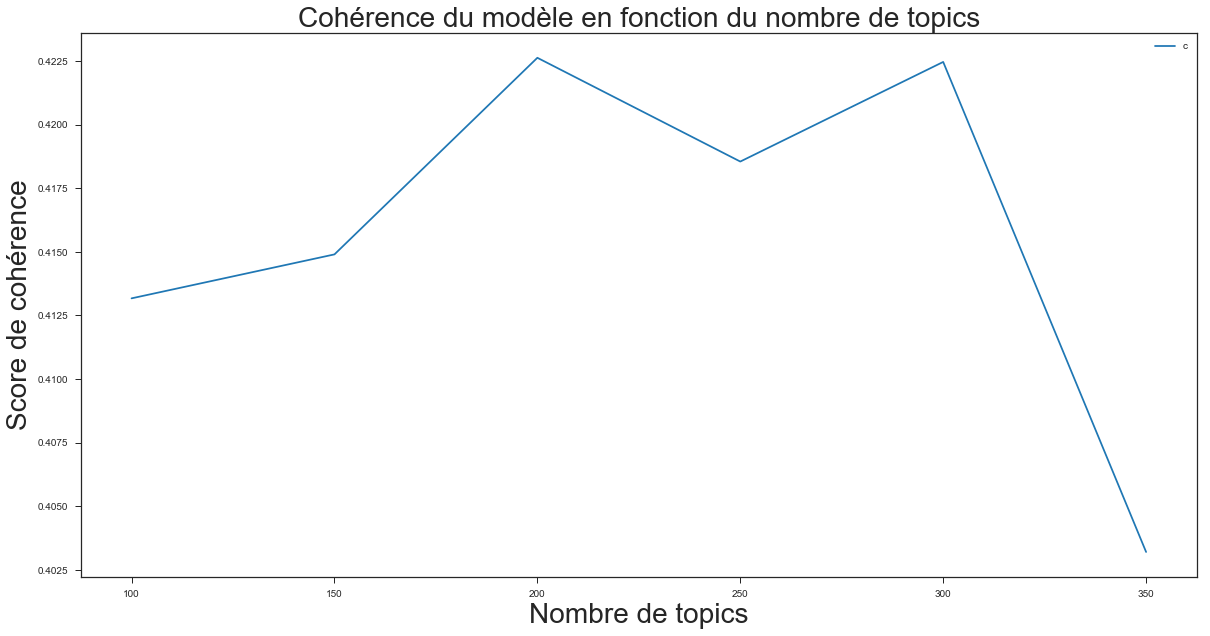

In [65]:
print("Coherence : {}".format(max(coherence_values)))
print("Optimal num. of topics : {}".format(list(range(k_min, k_max, pas))[coherence_values.index(max(coherence_values))]))

# Show graph
# Coherence scores
start= k_min
limit= k_max
step=pas;
x = range(start, limit, step)
plt.figure(figsize=(20,10))
plt.title("Cohérence du modèle en fonction du nombre de topics", fontsize=28)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de topics", fontsize=28)
plt.ylabel("Score de cohérence", fontsize=28)
plt.legend(("coherence_values"), loc='best')
plt.show()


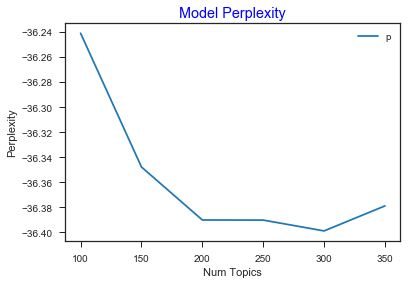

In [31]:
# Show graph
# Perplexity values
x = range(start, limit, step)
plt.title("Model Perplexity", color="b", fontsize="x-large")
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')
plt.show()

### Optimal Model

In [32]:
num_topics = 200
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=10, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Wall time: 2min 51s


## Topic Visualization

In [33]:
import pyLDAvis
import pyLDAvis.gensim
import gensim
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary_LDA)
pd.options.display.max_colwidth = 5000
pyLDAvis.display(vis)

## Model Performance

In [34]:
# Compute Perplexity
print('\nlog_Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = coherencemodel.CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


log_Perplexity:  -10.222299410045581

Coherence Score:  0.4464397321383274


# Contrsuction de la matrice Topic - Tags pour affecter des tags à une sortie de LDA

## Matrix Questions - Tags 

In [35]:
tags_unique = [item for sublist in Tokens_Tags_train['Tags'] for item in sublist]
print(len(tags_unique))
tags_unique = list(set(tags_unique))
print(len(tags_unique))

34060
1498


In [36]:
tags_unique = list(tags_unique)
tags_unique = [t.replace("'","") for t in tags_unique]
tags_unique

['static',
 'database-design',
 'daemon',
 'set',
 'shell',
 'mysql-workbench',
 'cocoapods',
 'jquery-ui',
 'visual-studio-2012',
 'xml',
 'relativelayout',
 'assembly',
 'desktop',
 'typeof',
 'statusbar',
 'uniqueidentifier',
 'swing',
 'embedded',
 'rounding',
 'gradient',
 'python-internals',
 'encapsulation',
 'sysadmin',
 'drop-down-menu',
 'artificial-intelligence',
 'user-defined-functions',
 'signed',
 'machine-learning',
 'user-agent',
 'diacritics',
 '.net-attributes',
 'kill',
 'terminology',
 'decode',
 'language-features',
 'svg',
 'google-chrome',
 'underscore.js',
 'guid',
 'stdvector',
 'c#-3.0',
 'wpf-controls',
 'copy-paste',
 'angularjs-scope',
 'android-activity',
 'oauth',
 '64bit',
 'colors',
 'xamarin.ios',
 'tcp',
 'github-pages',
 'activerecord',
 'back',
 'sizeof',
 'controls',
 'curl',
 'avd',
 'html-select',
 'dynamic',
 'python-requests',
 'npm',
 'inner-join',
 'easy-install',
 'variable-assignment',
 'warnings',
 'multiline',
 'plot',
 'go',
 'laravel-4

In [37]:
dict_tags = dict(zip(Tokens_Tags_train.index, Tokens_Tags_train['Tags']))
Quest_Tags = pd.DataFrame(dict_tags, index=range(
    Tokens_Tags_train.shape[0]), columns=tags_unique, dtype=float)

In [38]:
for line in range(len(dict_tags)):
    for tag in dict_tags[line]:
        if tag in tags_unique:
            Quest_Tags.loc[line,tag] = 1 
            
Quest_Tags = Quest_Tags.fillna(0)

In [39]:
Quest_Tags.shape

(12934, 1498)

## Matrix Questions - Topics 

In [40]:
mixture = [dict(lda_model[x]) for x in corpus]

In [41]:
Quest_Topic = pd.DataFrame(mixture, dtype=float)
Quest_Topic = Quest_Topic.fillna(0)

In [42]:
Quest_Topic.shape

(12934, 200)

## Topic Tags Matrix

In [43]:
Mat_Topic_Tag = pd.DataFrame(np.matmul(Quest_Topic.T, Quest_Tags), columns = tags_unique)

### Tag probability of a document

In [44]:
vec_doc_top = lda_model.get_document_topics(corpus[0])
print(vec_doc_top)

[(13, 0.05025), (16, 0.025249999), (20, 0.05025), (32, 0.03632646), (34, 0.025252443), (45, 0.089788094), (53, 0.025249999), (54, 0.07800303), (66, 0.2066973), (71, 0.025884267), (79, 0.02816001), (90, 0.02492056), (96, 0.05025), (107, 0.051466547), (114, 0.026204292), (153, 0.034994192), (177, 0.025250003), (193, 0.07525), (198, 0.025302812)]


### Fonction permettant de sortir les meilleurs tags pour un document tokenisé

In [45]:
def get_tags_bylda_rawdoc(Doc, N_best=3): 
    Doc = dictionary_LDA.doc2bow(Doc)
    
    num_topic = num_topics
    res_lda = lda_model.get_document_topics(Doc)
    vec = np.zeros(num_topic)

    for tupl in range(len(res_lda)):
         for topic in range(num_topic):
            if topic == res_lda[tupl][0]:
                vec[topic] = res_lda[tupl][1]
                
    distri_tags = pd.DataFrame(np.matmul(Mat_Topic_Tag.T, vec), columns=['Score'], index=tags_unique)
    distri_tags = distri_tags.reset_index(drop=False)
    best_tags = distri_tags[distri_tags['Score'] > distri_tags['Score'].quantile(.99)]
    best_tags = best_tags.dropna()
    best_tags = best_tags.sort_values('Score', ascending = False)
    best_tags = best_tags.reset_index(drop=True)
    tags = best_tags['index'][:N_best].tolist()
    return(tags, best_tags[:N_best])

In [46]:
get_tags_bylda_rawdoc(Tokens_Tags_test['Tokens'][80], 10)

(['python',
  'javascript',
  'java',
  'c#',
  'c++',
  'android',
  '.net',
  'git',
  'jquery',
  'html'],
         index      Score
 0      python  12.258529
 1  javascript  12.242760
 2        java  11.540397
 3          c#  11.104011
 4         c++   6.112132
 5     android   5.512590
 6        .net   5.199422
 7         git   4.995457
 8      jquery   4.863303
 9        html   4.490474)

In [47]:
Test = get_tags_bylda_rawdoc(Tokens_Tags_test['Tokens'][7], 10)

In [48]:
Test

(['java',
  'javascript',
  'c#',
  'python',
  'c++',
  '.net',
  'android',
  'git',
  'jquery',
  'c'],
         index     Score
 0        java  8.041686
 1  javascript  5.897339
 2          c#  5.831381
 3      python  5.379221
 4         c++  4.326433
 5        .net  3.585299
 6     android  3.127313
 7         git  2.596096
 8      jquery  2.406051
 9           c  2.345774)

In [49]:
pred_Tags = Test[1]['index'][:5].tolist()
print(pred_Tags)
print(Tokens_Tags_test['Tags'][7])

['java', 'javascript', 'c#', 'python', 'c++']
['java', 'spring']


In [50]:
np.intersect1d(pred_Tags, Tokens_Tags_test['Tags'][7])

array(['java'], dtype='<U10')

# Implémentation de la méthode d'évaluation de la métrique du problème

### 3 métriques étudiées : Rappel - Précision - Personnalisée

In [51]:
def get_score_perso(Doc_Test, Tags):
    res = get_tags_bylda_rawdoc(Doc_Test, 5)[0]
    tags = Tags
    Note = len(np.intersect1d(res, tags)) / len(tags)
    return(Note)

In [52]:
get_score_perso(Tokens_Tags_test['Tokens'][700], Tokens_Tags_test['Tags'][700])

0.3333333333333333

In [53]:
def get_score_byID_perso(ID, n_tags):
    res = get_tags_bylda_rawdoc(Tokens_Tags_test['Tokens'][ID], n_tags)[0]
    tags = Tokens_Tags_test['Tags'][ID]
    if len(tags) == 0: 
        Note = 0
    else: 
        Note = len(np.intersect1d(res, tags)) / hmean((n_tags,len(tags)))
    return(Note)

In [54]:
def get_score_byID_rappel(ID, n_tags):
    res = get_tags_bylda_rawdoc(Tokens_Tags_test['Tokens'][ID], n_tags)[0]
    tags = Tokens_Tags_test['Tags'][ID]
    if len(tags) == 0: 
        Note = 0
    else: 
        Note = len(np.intersect1d(res, tags)) / len(tags)
    return(Note)

In [55]:
def get_score_byID_precision(ID, n_tags):
    res = get_tags_bylda_rawdoc(Tokens_Tags_test['Tokens'][ID], n_tags)[0]
    tags = Tokens_Tags_test['Tags'][ID]
    if len(tags) == 0: 
        Note = 0
    else: 
        Note = len(np.intersect1d(res, tags)) / (n_tags)
    return(Note)

In [56]:
print("La métrique perso est",get_score_byID_perso(30, 3))
print("le rappel est ",get_score_byID_rappel(30, 3))
print("la précision est de ",get_score_byID_precision(30, 3))

La métrique perso est 0.29166666666666663
le rappel est  0.25
la précision est de  0.3333333333333333


In [57]:
def note_totale_perso(Range, n_tags):
    Note = 0 
    for i in range(Range): 
        Note = Note + get_score_byID_perso(i, n_tags)
    
    Note_f = Note / Range
    
    return(Note_f, Note, Range)
    


In [58]:
def note_totale_rappel(Range, n_tags):
    Note = 0 
    for i in range(Range): 
        Note = Note + get_score_byID_rappel(i, n_tags)
    
    Note_f = Note / Range
    
    return(Note_f, Note, Range)
    

In [59]:
def note_totale_precision(Range, n_tags):
    Note = 0 
    for i in range(Range): 
        Note = Note + get_score_byID_precision(i, n_tags)
    
    Note_f = Note / Range
    
    return(Note_f, Note, Range)
    

In [60]:
print("la métrique perso est ", note_totale_perso(Tokens_Tags_test['Tokens'].shape[0], 3))
print(" le rappel est de", note_totale_rappel(Tokens_Tags_test['Tokens'].shape[0], 3))
print(" la précision est de : ", note_totale_precision(Tokens_Tags_test['Tokens'].shape[0], 3))

la métrique perso est  (0.1708816481137896, 736.8416666666608, 4312)
 le rappel est de (0.19250927643784935, 830.1000000000064, 4312)
 la précision est de :  (0.14973716759431097, 645.6666666666689, 4312)


### Evolution de la note en fonction des tags prédits

In [61]:
note=[]
for i in [1,2,3,4,5,6,7,8,9]:
    note.append(note_totale_perso(Tokens_Tags_test.shape[0], i)[0])

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


NameError: name 'note_totale' is not defined

In [ ]:
#print(note)
print(max(note), note.index(max(note)))

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.plot(note)
plt.title("Evolution de la note en fonction du nombre de tags prédits", fontsize = 30)